# Question 1


###  Import Necessary Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import ndimage, spatial
import math


### Load and Display the Image

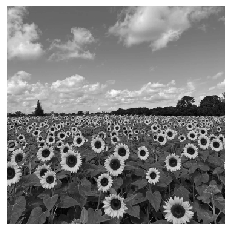

Image Shape: (360, 360)


In [14]:
# Load the image and convert it to grayscale
img = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
assert img is not None  # Ensure the image loaded successfully

# Display the original image
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap="gray")
ax.set_axis_off()
plt.show()

print("Image Shape:", img.shape)  # Print the shape of the image

###  Define the Laplacian of Gaussian (LoG) Filter

In [15]:
# Parameters for the LoG filter
k = 1.414  # Scale multiplier
sigma = 3.0  # Initial sigma value
img = img / 255.0  # Normalize pixel values to [0, 1]

def LoG(sigma):
    n = np.ceil(sigma * 6)  # Determine filter window size
    y, x = np.ogrid[-n//2:n//2+1, -n//2:n//2+1]
    y_filter = np.exp(-(y * y) / (2.0 * sigma * sigma))
    x_filter = np.exp(-(x * x) / (2.0 * sigma * sigma))
    final_filter = (-(2 * sigma**2) + (x * x + y * y)) * (x_filter * y_filter) / (2 * np.pi * sigma**4)
    return final_filter


### Apply the LoG Filter Across Multiple Scales

In [17]:
def LoG_convolve(img):
    log_images = []
    for i in range(1, 10):
        y = np.power(k, i)
        sigma_1 = sigma * y
        filter_log = LoG(sigma_1)
        image = cv.filter2D(img, -1, filter_log)
        image = np.pad(image, ((1, 1), (1, 1)), 'constant')
        image = np.square(image)
        log_images.append(image)
    return np.array(log_images)

log_image_np = LoG_convolve(img)
print("Shape of LoG Filtered Images:", log_image_np.shape)


Shape of LoG Filtered Images: (9, 362, 362)


### Detect and Remove Redundant Blobs

In [20]:
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = math.sqrt(n_dim)

    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim

    d = math.sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))

    if d > r1 + r2:
        return 0  # No overlap
    elif d <= abs(r1 - r2):
        return 1  # One blob is inside the other
    else:
        ratio1 = (d**2 + r1**2 - r2**2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d**2 + r2**2 - r1**2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1**2 * acos1 + r2**2 * acos2 - 0.5 * math.sqrt(abs(a * b * c * d)))
        return area / (math.pi * min(r1, r2)**2)

def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * math.sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))

    if len(pairs) == 0:
        return blobs_array

    for i, j in pairs:
        blob1, blob2 = blobs_array[i], blobs_array[j]
        if blob_overlap(blob1, blob2) > overlap:
            if blob1[-1] > blob2[-1]:
                blob2[-1] = 0
            else:
                blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])


### Detect Blobs from the LoG Images

In [21]:
def detect_blob(log_image_np):
    co_ordinates = []
    h, w = img.shape
    for i in range(1, h):
        for j in range(1, w):
            slice_img = log_image_np[:, i-1:i+2, j-1:j+2]
            result = np.amax(slice_img)
            if result >= 0.03:
                z, x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                co_ordinates.append((i + x - 1, j + y - 1, k**z * sigma))
    return co_ordinates

co_ordinates = list(set(detect_blob(log_image_np)))
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates, 0.5)


### Visualize the Detected Blobs

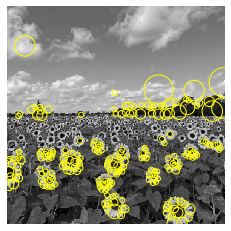

In [24]:
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap="gray")

radius = 0
for blob in co_ordinates:
    y, x, r = blob
    c = plt.Circle((x, y), r * 1.414, color='yellow', linewidth=1, fill=False)
    if r > radius:
        radius = r * 1.414
        param_x, param_y = x, y
    ax.add_patch(c)

ax.set_axis_off()
plt.show()


### Report the Parameters of the Largest Circle and σ Values

In [26]:
# Calculate the range of sigma values used
sigma_values = [sigma * (k ** i) for i in range(1, 10)]
min_sigma = min(sigma_values)
max_sigma = max(sigma_values)

# Report the largest circle's parameters and sigma range
print(f"Largest Circle Radius: {radius}")
print(f"Center Coordinates: ({param_x}, {param_y})")
print(f"Range of σ Values: {min_sigma} to {max_sigma}")


Largest Circle Radius: 23.978262566026945
Center Coordinates: (358.0, 125.0)
Range of σ Values: 4.242 to 67.7900477577101


## Loading and Preparing the Image

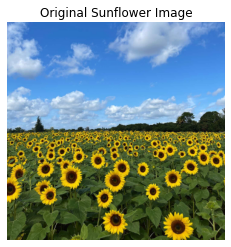

In [27]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
image_sunflower = cv.imread(filename=str('the_berry_farms_sunflower_field.jpeg'), flags=cv.IMREAD_REDUCED_COLOR_4)

# Display the original image
plt.imshow(cv.cvtColor(image_sunflower, cv.COLOR_BGR2RGB))
plt.axis(False)
plt.title("Original Sunflower Image")
plt.show()

### Define the Laplacian of Gaussian (LoG) function

In [28]:
# Define Laplacian of Gaussian function for blob detection
def laplacian_of_gaussian(sigma):
    filter_radius = round(3 * sigma)
    X, Y = np.meshgrid(np.arange(-filter_radius, filter_radius + 1), 
                       np.arange(-filter_radius, filter_radius + 1))
    LoG_filter = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (np.pi * sigma**4)
    return LoG_filter


### Local Maxima Detection Function

In [29]:
# Function to detect local maxima in the filtered image
def find_local_maxima(log_image, threshold):
    detected_points = []
    img_height, img_width = log_image.shape
    neighborhood_radius = 1
    
    for i in range(neighborhood_radius, img_height - neighborhood_radius):
        for j in range(neighborhood_radius, img_width - neighborhood_radius):
            local_window = log_image[i - neighborhood_radius:i + neighborhood_radius + 1, 
                                     j - neighborhood_radius:j + neighborhood_radius + 1]
            if np.max(local_window) >= threshold:
                y_offset, x_offset = np.unravel_index(local_window.argmax(), shape=local_window.shape)
                detected_points.append((i + y_offset - neighborhood_radius, j + x_offset - neighborhood_radius))
    
    return set(detected_points)


### Blob Detection at Multiple Scales

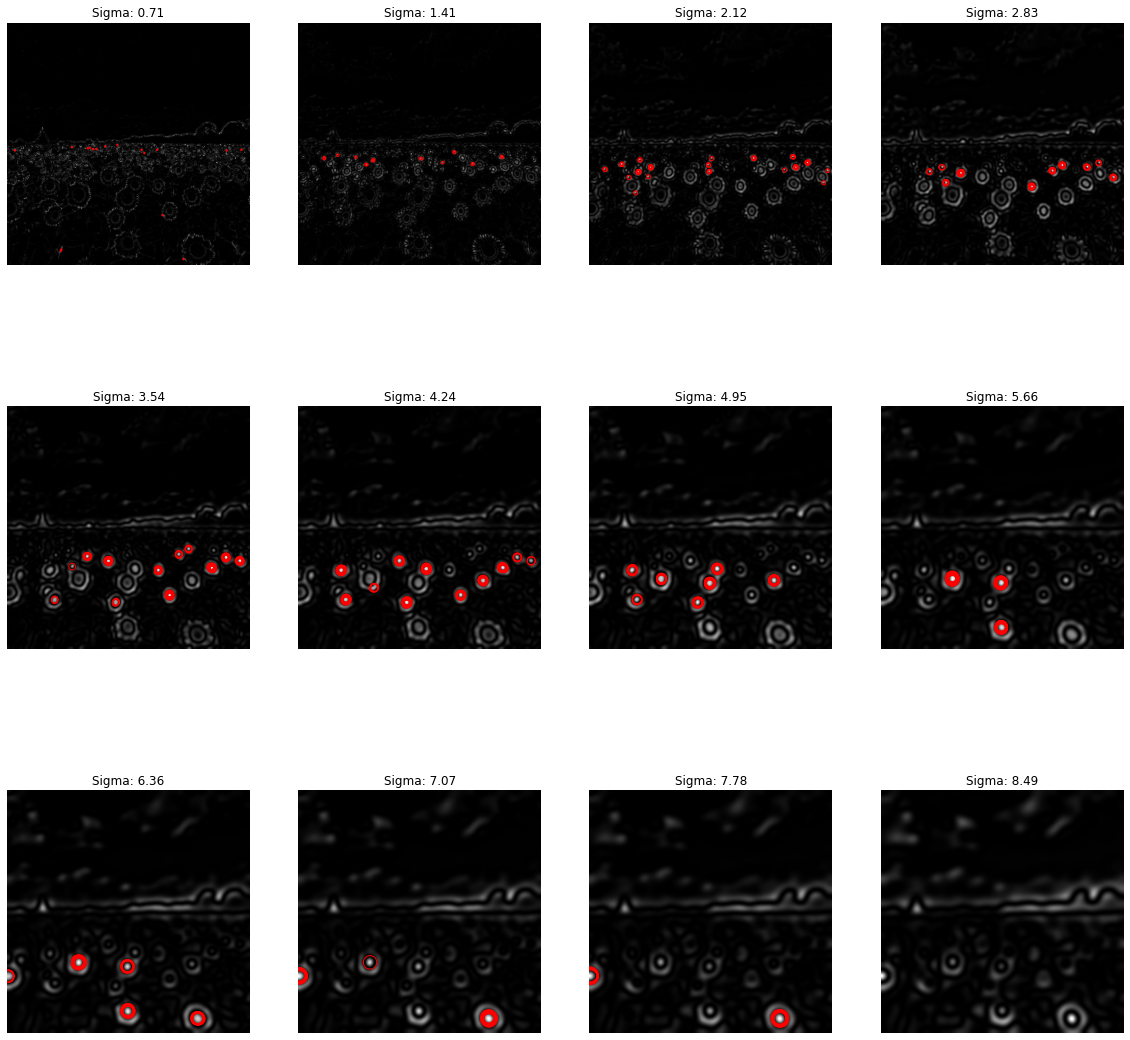

In [30]:
# Prepare the image for processing
image_gray = cv.cvtColor(image_sunflower, cv.COLOR_BGR2GRAY) / 255

# Variables to track the largest circle
largest_circle_radius = 0
largest_circle_sigma = 0

# Plot detected blobs for a range of sigma values
sigma_values = []
fig, axes = plt.subplots(3, 4, figsize=(20, 20))

for idx, ax in enumerate(axes.flatten(), start=1):
    sigma = idx / np.sqrt(2)
    sigma_values.append(sigma)
    
    # Apply Laplacian of Gaussian filtering
    LoG_kernel = sigma**2 * laplacian_of_gaussian(sigma)
    filtered_image = np.square(cv.filter2D(src=image_gray, ddepth=-1, kernel=LoG_kernel))
    
    # Detect local maxima
    detected_points = find_local_maxima(filtered_image, 0.09)
    
    # Track the largest circle based on sigma (radius)
    if detected_points:
        current_radius = sigma * 1.414  # Approximate radius based on sigma
        if current_radius > largest_circle_radius:
            largest_circle_radius = current_radius
            largest_circle_sigma = sigma

    # Display the filtered image with detected circles
    ax.imshow(filtered_image, cmap='gray')
    ax.set_title(f'Sigma: {sigma:.2f}')
    ax.axis('off')

    for y, x in detected_points:
        circle = plt.Circle((x, y), sigma * 1.414, color='red', linewidth=1, fill=False)
        ax.add_patch(circle)

plt.show()


### Finding and Reporting the Largest Circles

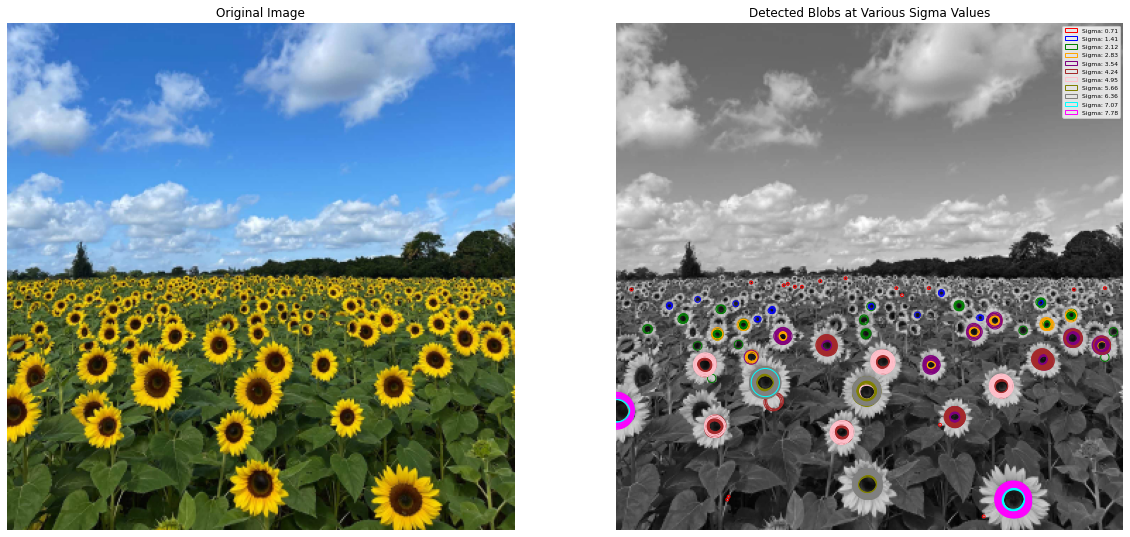

In [31]:
# Second visualization with color-coded circles for different sigma values
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

# Show the original image
axes[0].imshow(cv.cvtColor(image_sunflower, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show grayscale image with color-coded circles for detected blobs
ax = axes[1]
ax.imshow(image_gray, cmap='gray')
ax.grid(False)

# Define colors for different sigma values
color_palette = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 
                 'pink', 'olive', 'gray', 'cyan', 'magenta']

patches = []
labels = []

for idx in range(1, 12):
    sigma = idx / np.sqrt(2)
    LoG_kernel = sigma**2 * laplacian_of_gaussian(sigma)
    filtered_image_log = np.square(cv.filter2D(image_gray, -1, LoG_kernel))
    
    # Detect local maxima
    detected_points = find_local_maxima(filtered_image_log, 0.09)
    
    # Draw circles around the detected points
    for y, x in detected_points:
        circle = plt.Circle((x, y), sigma * 1.414, color=color_palette[idx-1], linewidth=1, fill=False)
        ax.add_patch(circle)
    
    patches.append(circle)
    labels.append(f'Sigma: {sigma:.2f}')
    
# Plot legend
ax.set_xlim(0, image_gray.shape[1])
plt.axis('off')
ax.legend(patches, labels, loc='best', fontsize=6)
ax.set_title("Detected Blobs at Various Sigma Values")
plt.show()

In [32]:
# Report the parameters of the largest circle (radius and corresponding sigma)
print(f"Largest circle detected has a radius of: {largest_circle_radius:.2f} pixels at sigma: {largest_circle_sigma:.2f}")

# Report the range of sigma values used
print(f"Range of sigma values used: {min(sigma_values):.2f} to {max(sigma_values):.2f}")


Largest circle detected has a radius of: 11.00 pixels at sigma: 7.78
Range of sigma values used: 0.71 to 8.49
